In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Policy(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Policy, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

class Value(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(Value, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value
    
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = Policy(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):  # randomly sample an action according to the probability distribution
        state = torch.tensor(state.reshape(1, -1), dtype=torch.float).to(self.device) 
                                                                      
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs) 
        action = action_dist.sample()
        return action.item()  
    

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # Back to Front, calc G
            reward = reward_list[i]
            state = torch.tensor(state_list[i].reshape(1, -1),
                                 dtype=torch.float).to(self.device)
            action = torch.tensor(action_list[i]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))  # calc log probability of action
            G = self.gamma * G + reward  # calculate return starting from this step
            loss = -log_prob * G         # loss of each step
            loss.backward()              # The gradient will be accumulated in each step
        self.optimizer.step()





In [2]:
    
class REINFORCE1:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device,v_lr):
        self.policy_net = Policy(state_dim, hidden_dim, action_dim).to(device)
        self.value_net=Value(state_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)
        self.voptimizer=torch.optim.Adam(self.value_net.parameters(),lr=v_lr)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):  # randomly sample an action according to the probability distribution
        state = torch.tensor(state.reshape(1, -1), dtype=torch.float).to(self.device) 
                                                                      
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs) 
        action = action_dist.sample()
        return action.item()
    

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        self.voptimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # Back to Front, calc G
            reward = reward_list[i]
            state = torch.tensor(state_list[i].reshape(1, -1),
                                 dtype=torch.float).to(self.device)
            action = torch.tensor(action_list[i]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))  # calc log probability of action
            G = self.gamma * G + reward  # calculate return starting from this step
            state_value=self.value_net(state)
            loss = -log_prob * (G - state_value)    # loss of each step
            loss.backward(retain_graph=True) # The gradient will be accumulated in each step
            
        self.optimizer.step()
        target_value = torch.tensor([[G]], dtype=torch.float).to(self.device)  # Target value is the calculated return G

        # Calculate the Mean Squared Error loss
        value_loss = F.mse_loss(state_value, target_value)

        # Backpropagate and update the value network
        value_loss.backward(retain_graph=True)
        self.voptimizer.step()






In [3]:
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch



def train_agent(env_name, num_episodes, seed):
    # create environment
    env = gym.make(env_name)
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # create agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)
    # record episode return, for plotting
    return_list = []
    # train agent
    for i_episode in range(num_episodes):
        episode_return = 0 # return of the whole episode
        transition_dict = { # store transitions of the episode
            "states": [],
            "actions": [],
            "next_states": [],
            "rewards": [],
            "dones": []
        }
        state, _ = env.reset() # reset environment
        terminated, truncated = False, False
        while not terminated and not truncated:
            action = agent.take_action(state) # select an action
            next_state, reward, terminated, truncated, _ = env.step(action) # take action and get next state, reward, termination signal
            # store transition
            transition_dict["states"].append(state)
            transition_dict["actions"].append(action)
            transition_dict["next_states"].append(next_state)
            transition_dict["rewards"].append(reward)
            transition_dict["dones"].append(terminated)
            state = next_state
            episode_return += reward
        # add episode return to return list
        return_list.append(episode_return)
        # update agent per episode(MC)
        agent.update(transition_dict)
    return return_list



def train_agent1(env_name, num_episodes, seed):
    # create environment
    env = gym.make(env_name)
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # create agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = REINFORCE1(state_dim, hidden_dim, action_dim, learning_rate, gamma, device,v_lr)
    # record episode return, for plotting
    return_list = []
    # train agent
    for i_episode in range(num_episodes):
        episode_return = 0 # return of the whole episode
        transition_dict = { # store transitions of the episode
            "states": [],
            "actions": [],
            "next_states": [],
            "rewards": [],
            "dones": []
        }
        state, _ = env.reset() # reset environment
        terminated, truncated = False, False
        while not terminated and not truncated:
            action = agent.take_action(state) # select an action
            next_state, reward, terminated, truncated, _ = env.step(action) # take action and get next state, reward, termination signal
            # store transition
            transition_dict["states"].append(state)
            transition_dict["actions"].append(action)
            transition_dict["next_states"].append(next_state)
            transition_dict["rewards"].append(reward)
            transition_dict["dones"].append(terminated)
            state = next_state
            episode_return += reward
        # add episode return to return list
        return_list.append(episode_return)
        # update agent per episode(MC)
        agent.update(transition_dict)
    return return_list

In [4]:
# Cartpole without baseline

# agent params
learning_rate = 0.0009498
gamma = 0.99
hidden_dim = 256
# training params

num_pbar = 10
num_episodes = 500
num_seeds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# environment params
env_name = "CartPole-v1"
# Collect episode returns for each seed
episode_returns_all_seeds_1 = []
for seed in range(num_seeds):
    episode_returns = train_agent(env_name, num_episodes, seed)
    episode_returns_all_seeds_1.append(episode_returns)

######################################################################################

#Cartpole with Baseline
    
# agent params
learning_rate = 0.005771
gamma = 0.99
hidden_dim = 64
v_lr=0.002084
# training params
num_pbar = 10
num_episodes = 500
num_seeds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# environment params
env_name = "CartPole-v1"
episode_returns_all_seeds_2 = []
for seed in range(num_seeds):
    episode_returns = train_agent1(env_name, num_episodes, seed)
    episode_returns_all_seeds_2.append(episode_returns)
###############################################################################


C:\Users\Shobhith Vadlamudi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


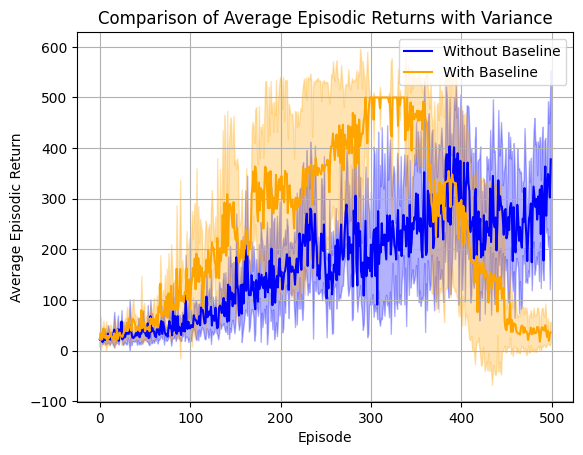

In [5]:

avg_episode_returns_1 = np.mean(episode_returns_all_seeds_1, axis=0)
variance_episode_returns_1 = np.std(episode_returns_all_seeds_1, axis=0)
avg_episode_returns_2 = np.mean(episode_returns_all_seeds_2, axis=0)
variance_episode_returns_2 = np.std(episode_returns_all_seeds_2, axis=0)

plt.plot(avg_episode_returns_1, label='Without Baseline', color='blue')
plt.fill_between(range(len(avg_episode_returns_1)), avg_episode_returns_1 - variance_episode_returns_1,
                 avg_episode_returns_1 + variance_episode_returns_1, color='blue', alpha=0.3)

plt.plot(avg_episode_returns_2, label='With Baseline', color='orange')
plt.fill_between(range(len(avg_episode_returns_2)), avg_episode_returns_2 - variance_episode_returns_2,
                 avg_episode_returns_2 + variance_episode_returns_2, color='orange', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Average Episodic Return')
plt.title('Comparison of Average Episodic Returns with Variance')
plt.legend()
plt.grid(True)
plt.show()

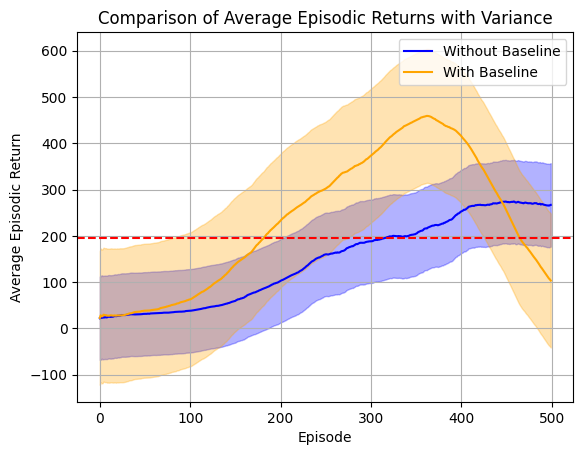

In [6]:
# Calculate average for each episode (including moving average for the first 100 episodes)
avg_episode_returns_1 = []
for i in range(num_episodes):
    if i < 100:
        avg_return = np.mean([np.mean(episode[:i+1]) for episode in episode_returns_all_seeds_1])
    else:
        avg_return = np.mean([episode[i-100:i+1] for episode in episode_returns_all_seeds_1])
    avg_episode_returns_1.append(avg_return)

avg_episode_returns_2 = []
for i in range(num_episodes):
    if i < 100:
        avg_return = np.mean([np.mean(episode[:i+1]) for episode in episode_returns_all_seeds_2])
    else:
        avg_return = np.mean([episode[i-100:i+1] for episode in episode_returns_all_seeds_2])
    avg_episode_returns_2.append(avg_return)

# Calculate variance for each episode
variance_episode_returns_1 = np.std(avg_episode_returns_1, axis=0)
variance_episode_returns_2 = np.std(avg_episode_returns_2, axis=0)

# Plot average episodic returns with variance
plt.plot(avg_episode_returns_1, label='Without Baseline', color='blue')
plt.fill_between(range(len(avg_episode_returns_1)), avg_episode_returns_1 - variance_episode_returns_1,
                 avg_episode_returns_1 + variance_episode_returns_1, color='blue', alpha=0.3)

plt.plot(avg_episode_returns_2, label='With Baseline', color='orange')
plt.fill_between(range(len(avg_episode_returns_2)), avg_episode_returns_2 - variance_episode_returns_2,
                 avg_episode_returns_2 + variance_episode_returns_2, color='orange', alpha=0.3)
plt.axhline(y=195, color='red', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Average Episodic Return')
plt.title('Comparison of Average Episodic Returns with Variance')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
 # Acrobot without baseline
learning_rate = 0.00977
gamma = 0.99
hidden_dim = 256
# training params
num_pbar = 10
num_episodes = 500
num_seeds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# environment params
env_name_2 = "Acrobot-v1"

episode_returns_all_seeds_1 = []
for seed in range(num_seeds):
    episode_returns = train_agent(env_name_2, num_episodes, seed)
    episode_returns_all_seeds_1.append(episode_returns)

########################################################################################################
# agent params
# Acrobot with baseline
    
learning_rate = 0.008181
gamma = 0.99
hidden_dim = 64
v_lr= 0.007159
# training params
num_pbar = 10
num_episodes = 500
num_seeds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# environment params
env_name_2 = "Acrobot-v1"

episode_returns_all_seeds_2 = []
for seed in range(num_seeds):
    episode_returns = train_agent1(env_name_2, num_episodes, seed)
    episode_returns_all_seeds_2.append(episode_returns)


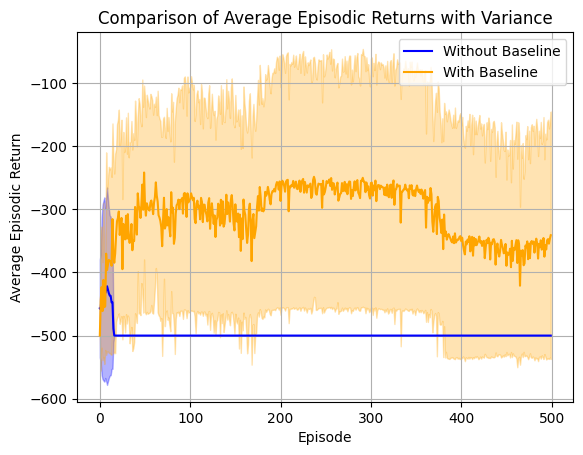

In [8]:

avg_episode_returns_1 = np.mean(episode_returns_all_seeds_1, axis=0)
variance_episode_returns_1 = np.std(episode_returns_all_seeds_1, axis=0)
avg_episode_returns_2 = np.mean(episode_returns_all_seeds_2, axis=0)
variance_episode_returns_2 = np.std(episode_returns_all_seeds_2, axis=0)

plt.plot(avg_episode_returns_1, label='Without Baseline', color='blue')
plt.fill_between(range(len(avg_episode_returns_1)), avg_episode_returns_1 - variance_episode_returns_1,
                 avg_episode_returns_1 + variance_episode_returns_1, color='blue', alpha=0.3)

plt.plot(avg_episode_returns_2, label='With Baseline', color='orange')
plt.fill_between(range(len(avg_episode_returns_2)), avg_episode_returns_2 - variance_episode_returns_2,
                 avg_episode_returns_2 + variance_episode_returns_2, color='orange', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Average Episodic Return')
plt.title('Comparison of Average Episodic Returns with Variance')
plt.legend()
plt.grid(True)
plt.show()